
Zillah Calle (1015365), Luc Dael (x), Leendert Borgers (x), Colm Keyes (x), Jord Van Rossum (x), Paula Castro Brandão (x)

# **ACT Project 11 - EcoGoggle - Version 2022**


# **Environment set-up**

The codeblock below imports the needed packages.


In [ ]:
## Importing tabular data
import pandas as pd

## Plotting and visualization
from matplotlib import pyplot as plt
from PIL import Image

import numpy as np
import random

## sklearn 
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.preprocessing import scale, StandardScaler

## patterns 
import cv2
from google.colab.patches import cv2_imshow
import skimage.feature as feature


# **Importing and preparing data**

The input features (High resolution RGB, NIR, plantheight, DEM, aspect and slope) are opened. The input will be normalized and the pixels outsite the study area are removed. The data input for the chosen unsupervised model, Gaussian Mixture Model, should be an array of shape (n_samples, n_dimensions). Therefore the data is transformed into this shape.

From the high resolution red band and the NIR band the NDVI is calculated. The NDVI is a vegetation cover index that will also be used as input for the model.

The hue is calculated from the RGB values. 

Lets start with opening the data files:

(1634, 1899, 3)
(1634, 1899, 3)


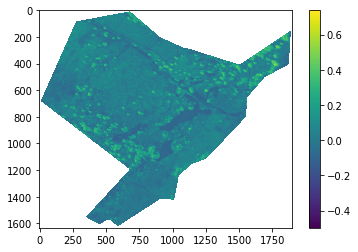

In [ ]:
# open the masked NIR image 
im1 = Image.open('ortho25IRmasked.tif')
IR = np.array(im1)
print(IR.shape)

# open the masked RGB image 
im2 = Image.open('orthoHRmasked.tif')
RGB = np.array(im2)
print(RGB.shape)

# open the vegetation height image
im3 = Image.open('veg_Height_75RES_2.tif')
veg = np.array(im3)

# open the DEM (Digital Elevation Model) image
im4 = Image.open('DEM_studyarea.tif')
DEM = np.array(im4)

# open the slope image
im5 = Image.open('slope_studyarea.tif')
slope = np.array(im5)

# open the aspect image
im6 = Image.open('aspect_studyarea.tif')
aspect = np.array(im6)

# select only the red band and set 0s to nan 
RED = RGB[:,:,0]
RED = RED.astype('float')
RED[RED == 0] = 'nan'

# select only the NIR band and set 0s to nan 
NIR = IR[:,:,0]
NIR = NIR.astype('float')
NIR[NIR == 0] = 'nan'

# set values outside study area to nan
veg[np.isnan(RED)] = 'nan'
DEM[np.isnan(RED)] = 'nan'
aspect[np.isnan(RED)] = 'nan'
slope[np.isnan(RED)] = 'nan'

# Calculate the NDVI 
NDVI= (NIR-RED)/(NIR+RED)

# plot NDVI to check correctness 
plt.imshow(NDVI)
plt.colorbar()


The code below extracts patterns textures from the RGB image. We decided not to use this, as it mainly detect edges and we don't expect different plant species at these edges.

Histogram of Local Binary Pattern value: [0.02177272 0.01835599 0.00591853 0.00323948 0.00220144 0.00175219
 0.00156044 0.00148149 0.00153273 0.00163392 0.00187562 0.00233841
 0.00258881 0.00241543 0.00216438 0.00203354 0.00199197 0.00192203
 0.00201742 0.00216503 0.00249439 0.00361428 0.0062234  0.01704692
 0.52511726 0.36454218]


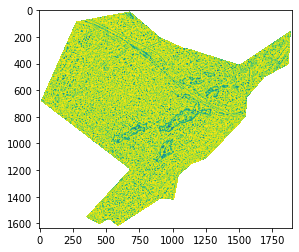

In [ ]:
"""
class LocalBinaryPatterns:
  def __init__(self, numPoints, radius):
    self.numPoints = numPoints
    self.radius = radius

  def describe(self, image, eps = 1e-7):
    lbp = feature.local_binary_pattern(image, self.numPoints, self.radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, self.numPoints+3), range=(0, self.numPoints + 2))

    # Normalize the histogram
    hist = hist.astype('float')
    hist /= (hist.sum() + eps)

    return hist, lbp

gray = cv2.cvtColor(RGB, cv2.COLOR_BGR2GRAY)
graycom = feature.greycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256)

# Find the GLCM properties
contrast = feature.greycoprops(graycom, 'contrast')
dissimilarity = feature.greycoprops(graycom, 'dissimilarity')
homogeneity = feature.greycoprops(graycom, 'homogeneity')
energy = feature.greycoprops(graycom, 'energy')
correlation = feature.greycoprops(graycom, 'correlation')
ASM = feature.greycoprops(graycom, 'ASM')

gray = cv2.cvtColor(RGB, cv2.COLOR_BGR2GRAY)
desc = LocalBinaryPatterns(24, 8)
hist, lbp = desc.describe(gray)
print("Histogram of Local Binary Pattern value: {}".format(hist))

contrast = contrast.flatten()
dissimilarity = dissimilarity.flatten()
homogeneity = homogeneity.flatten()
energy = energy.flatten()
correlation = correlation.flatten()
ASM = ASM.flatten()
hist = hist.flatten()
lbp[np.isnan(RED)]= np.nan
plt.imshow(lbp)
"""

The hue is obtained:

(1634, 1899)

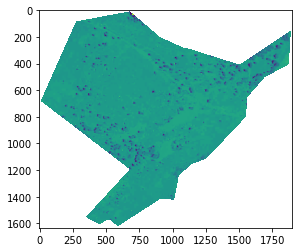

In [ ]:
#  get HSV (Hue Saturation Value) images using cv2 library and the RGB values
hsv_image = cv2.cvtColor(RGB, cv2.COLOR_BGR2HSV)

# set data points to float
hsv_image = hsv_image.astype('float')

# Set pixels outside study area to nan 
hsv_image[np.isnan(RED)] = np.nan 

# select only hue 
hue= hsv_image[:,:,0]

# plot the hue image and shape 
plt.imshow(hue)
hue.shape

All input features are put together in a feature space array (f_s):

In [ ]:
# to concatenate the arrays, they need to have a similar shape, therefore the arrays are reshaped
NIR= np.reshape(NIR,(1634, 1899, 1))
NDVI= np.reshape(NDVI,(1634, 1899, 1))

# lbp= np.reshape(lbp,(1634, 1899, 1))
veg= np.reshape(veg,(1634, 1899, 1))
hue= np.reshape(hue,(1634, 1899, 1))
DEM= np.reshape(DEM,(1634, 1899, 1))
aspect= np.reshape(aspect,(1634, 1899, 1))
slope= np.reshape(slope,(1634, 1899, 1))

# Add the arrays together in a feature space array 
f_s = np.concatenate((RGB,NIR,NDVI,veg,hue,DEM,aspect,slope),axis=-1)


To get to the correct model input the feature space is flatten, the nan values are removed and the data is normalized :

In [ ]:

print("The orignal shape is :" ,f_s.shape)

# Flatten the feature space
f_s_flat= f_s.reshape(1634*1899,f_s.shape[2])

# create a Mask 
mask = f_s[:,:,0] != 0
print("mask shape:", mask.shape)

# get study area pixels
f_s_nan = f_s[mask]
print("The new shape is :",f_s_nan.shape)

# normalize the input data 
scaler = StandardScaler()
model_input = scaler.fit_transform(f_s_nan)

The orignal shape is : (1634, 1899, 10)
mask shape: (1634, 1899)
The new shape is : (1545928, 10)


After normalizing the mean of each layer is aproximatly zero:

In [ ]:
# check means per layer 
np.nanmean(model_input, axis=0)

array([-3.76829923e-14, -7.36105956e-14,  7.98533396e-14, -3.71451770e-14,
        3.52695263e-13, -8.47254240e-13, -9.40766770e-14, -2.20575684e-14,
        1.06861803e-15, -1.40648192e-15])

For training the model only 10% of the pixels will be used, these pixels will be randomly sampled:


In [ ]:
# randomly select 10 % of the pixels
sampled_model_input= model_input[np.random.choice(f_s_nan.shape[0], size=int(f_s_nan.shape[0]/10), replace=False),:]
print("The sampled model input has shape :",sampled_model_input.shape)

The sampled model input has shape : (154592, 10)


*Note: If you want the model to run faster you could select a lower percentage of pixels here ( increase the number 10 in the code above).*

# **Selecting best feature space and the optimal number of clusters**

First the best feature space is selected based on backwards elimination. We start with all features and at each iteration we remove one feature. The feature that is removed is selected based on the lowest bayesian information criterion (BIC) of the resulting model. Afterwards, the best feature space is selected based on the overall lowest BIC value. 

In [ ]:
feature_names=("Red","Green","Blue","NIR","NDVI","veg","hue","DEM", "aspect","slope")
# initialize empty list 
BIC_list=[]
feature_list=[]
while sampled_model_input.shape[1]>1: # go through all possible number of features
  BIC=[]
  for i in range(sampled_model_input.shape[1]): # per number of features go through all possible combinations 
    sampled_model_input_sel = np.delete(sampled_model_input,i,1) # delete one feature 
    gm = GaussianMixture(n_components=8, n_init=4).fit(sampled_model_input_sel) # run the model 
    BIC.append(gm.bic(np.delete(model_input,i,1))) # calculate and append BIC values 
  index_removed= np.argmin(BIC) # get index of the feature that needs to be removed 
  print("The feature layer that will be removed :", feature_names[index_removed])
  feature_names= np.delete(feature_names,index_removed) # delete feature from feature names list 
  feature_list.append(feature_names)
  print("The new feature space :", feature_names)
  BIC_list.append(min(BIC)) # add the BIC value to the list 
  print("The corresponding BIC values :", min(BIC))
  sampled_model_input= np.delete(sampled_model_input,index_removed,1)  # remove feature from sampled input 
  model_input = np.delete(model_input,i,1) # remove feature from input 
  
print("The best feature space is :", feature_list[np.argmin(BIC_list)])

The feature layer that will be removed : aspect
The new feature space : ['Red' 'Green' 'Blue' 'NIR' 'NDVI' 'veg' 'hue' 'DEM' 'slope']
The corresponding BIC values : -16138709.60858305
The feature layer that will be removed : slope
The new feature space : ['Red' 'Green' 'Blue' 'NIR' 'NDVI' 'veg' 'hue' 'DEM']
The corresponding BIC values : -20408682.54239327
The feature layer that will be removed : DEM
The new feature space : ['Red' 'Green' 'Blue' 'NIR' 'NDVI' 'veg' 'hue']
The corresponding BIC values : -24236834.18608286
The feature layer that will be removed : NDVI
The new feature space : ['Red' 'Green' 'Blue' 'NIR' 'veg' 'hue']
The corresponding BIC values : -21402182.712189328
The feature layer that will be removed : veg
The new feature space : ['Red' 'Green' 'Blue' 'NIR' 'hue']
The corresponding BIC values : 19356020.83605143
The feature layer that will be removed : hue
The new feature space : ['Red' 'Green' 'Blue' 'NIR']
The corresponding BIC values : -2166118.841917551
The feature

The results are visualized in a bar plot. Note that models with a lower BIC are preferred.

The best feature space is : ['Red' 'Green' 'Blue' 'NIR' 'NDVI' 'veg' 'hue']


Text(0, 0.5, 'BIC')

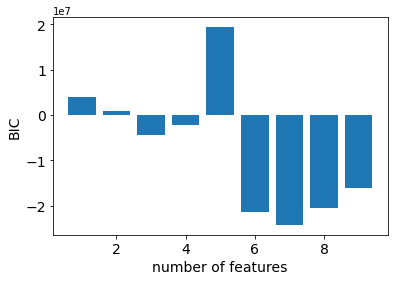

In [ ]:
plt.bar([9,8,7,6,5,4,3,2,1],BIC_list)
print("The best feature space is :", feature_list[np.argmin(BIC_list)])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14 )
plt.xlabel('number of features', fontsize=14)
plt.ylabel("BIC", fontsize=14)

A model input is created using the best feature space as selected above. Again, 10 % of the model input is sampled. 

In [ ]:
model_input = scaler.fit_transform(f_s_nan) # obtain the full model input 
# remove the selected features
model_input = np.delete(model_input,9,1)
model_input = np.delete(model_input,8,1)
model_input = np.delete(model_input,7,1)

feature_names = feature_list[np.argmin(BIC_list)] # get correct feature names
# when not running code block above (slow) comment line above and oncomment line below this line to get the correct feature space 
#feature_names = ['Red', 'Green', 'Blue', 'NIR', 'NDVI', 'veg', 'hue']

# randomly select 10 % of the pixels
sampled_model_input= model_input[np.random.choice(f_s_nan.shape[0], size=int(f_s_nan.shape[0]/10), replace=False),:]
print("The sampled model input has shape :",sampled_model_input.shape)


The sampled model input has shape : (154592, 7)


To select the best number of clusters (k), the Gaussian Mixture Model is run for a range of cluster numbers using the sampled pixels. The Calinski-Harabasz score (CHI) and the Davies-Bouldin index (DBI) are calculated for each k.  

In [ ]:
# initialize empty list 
DBI= []
CHI =[]
models=[]
for k in range(2,15): # loop over the number of clusters 
  gm = GaussianMixture(n_components=k, n_init=4).fit(sampled_model_input) # run the model 
  class_pred_flat = gm.predict(model_input) # predict the clusters 
  CHI.append(metrics.calinski_harabasz_score(model_input,class_pred_flat)) # calculate and append CHI
  DBI.append(metrics.davies_bouldin_score(model_input,class_pred_flat)) # calculate and append DBI
  models.append(gm) # list the models 
print(CHI)
print(DBI)

[221142.685769251, 183418.30010684364, 256212.86321991403, 309241.6927500685, 309466.8468555066, 267164.9273501787, 243441.4766873618, 286200.44415459246, 271525.06712442747, 224456.36208863676, 232784.98291420817, 195992.3922035797, 203254.2903539245]
[2.13980752403307, 2.297150697418184, 5.170060431923801, 5.4082717107129685, 3.2760334233252393, 4.956240787071183, 2.97932370253117, 3.789717290926982, 4.260727847247081, 9.110859960977164, 5.324920897727476, 4.3466035895477955, 4.209346213076837]


As a third matrix, the silhouette score is calculated. Calculating the silhouette score takes a long time as it is computationally expensive, therefore we only use 5% of the data for this calculation.

In [ ]:
# randomly select 5% of the data 
sampled_model_SI= model_input[np.random.choice(1537592, size=int(1537592/20), replace=False),:]
silhouette = []
for k in range(2,15): # loop over the number of cluster
  gm = GaussianMixture(n_components=k, n_init=4).fit(sampled_model_input)
  class_pred_flat = gm.predict(sampled_model_SI)
  silhouette.append(metrics.silhouette_score(sampled_model_SI,class_pred_flat))# calculate and append silhouette score
print(silhouette)


[0.249384670080495, -0.0019181300715884733, 0.008073305560892067, -0.009130127600608152, -0.026425724915839617, 0.0022332272559582927, 0.003507190761941103, -0.004085322387710236, -0.05288566149849299, -0.011483501141193677, -0.019485531497851132, -0.05579554745929299, -0.06264771646173563]


The three indexes are plotted and per index the best number of clusters is selected.

*note: a **higher** Calinski-Harabasz score relates to a model with better defined clusters (dense and well separated) and a **lower** Davies-Bouldin index relates to a model with better separation between the clusters.The best Silhouette value is 1 and the worst value is -1. So, the **higher** the Silhouette score the better the clustering.*

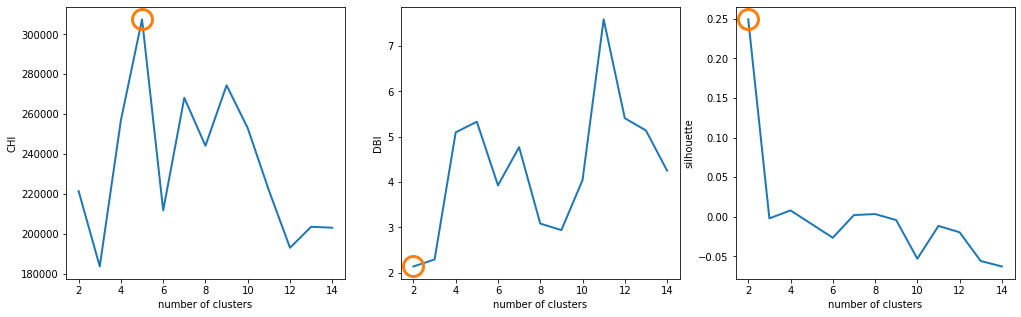

In [ ]:
fig, axs= plt.subplots(1,3, figsize=(17,5))

# CHI
axs[0].plot(range(2,15), CHI,linewidth=2)
max_CHI= np.argmax(CHI) +2
axs[0].set(xlabel='number of clusters', ylabel="CHI")
axs[0].plot(max_CHI, max(CHI),'o', mfc='none', markersize=20,markeredgewidth=3)

#DBI
axs[1].plot(range(2,15), DBI,linewidth=2)
min_DBI= np.argmin(DBI) +2
axs[1].set(xlabel='number of clusters', ylabel="DBI")
axs[1].plot(min_DBI, min(DBI),'o', mfc='none', markersize=20,markeredgewidth=3)

# silhoutte 
axs[2].plot(range(2,15), silhouette,linewidth=2)
max_silhouette= np.argmax(silhouette) +2
axs[2].set(xlabel='number of clusters', ylabel="silhouette")
axs[2].plot(max_silhouette, max(silhouette),'o', mfc='none', markersize=20,markeredgewidth=3)

To restore the data to the original state, the NaN values need to be re-inlcuded in the array, and the shape should be restored. 

In [ ]:
def get_original_shape(flat_input):
  # Gets the flat array of only study area pixels
  # Returns the original shape of the study area

  #initalise array of correct shape filled with nan's
  flat_nan= np.empty((3102966,1,))
  flat_nan[:] = np.nan

  # initialize the study area pixels 
  count=0

  for i in range(0,3102965): # loop over the orginal pixels 
    if f_s_flat[:,0][i]!=0: # select pixel locations study area
      flat_nan[i]=flat_input[count] # fill with value 
      count+=1
  return flat_nan.reshape(1634, 1899) # return the reshaped array 

Select the number of clusters of intrest (K), predict the classes and reshape to the original shape:

In [ ]:
K=14 # this number can be varied from 2 to 14
class_pred_flat = models[K-2].predict(model_input)
class_pred = get_original_shape(class_pred_flat)

The array containing the predictions can be saved to a csv file:

In [ ]:
pd.DataFrame(class_pred).to_csv("prediction_K{}.csv".format(K))

A plot of the study area is created:

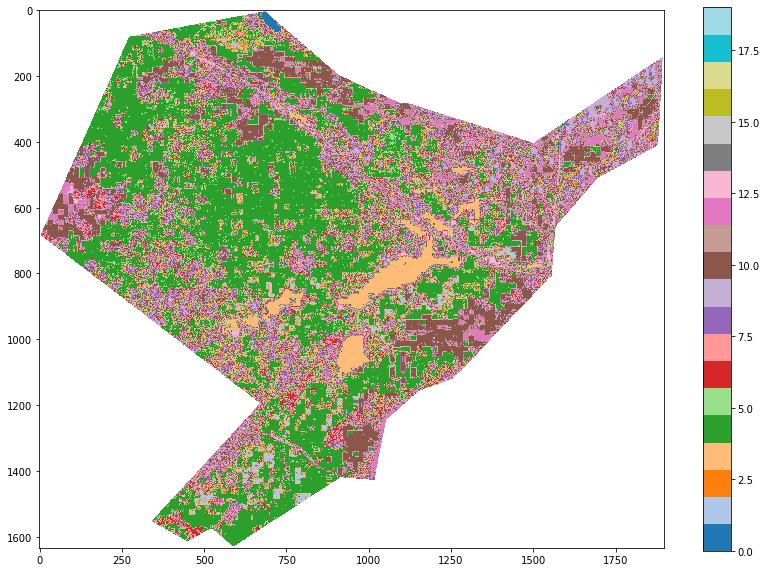

In [ ]:
import seaborn as sns
plt.figure(figsize=(14,10))

if K<11:
  plt.imshow(class_pred, cmap="tab10")
  plt.clim(0,9)
else:
  plt.imshow(class_pred, cmap='tab20')
  plt.clim(0,19)
plt.colorbar()
plt.savefig("cluster_map{}.png".format(K))

It is intresting to know how the clusters are formed based on the input features. The barplots below show the average feature value per cluster. 

*Note: Since the inputs where normalized, a positive value indicates a higher than average value of the input feature. While a negative value indicates a lower than average value.*

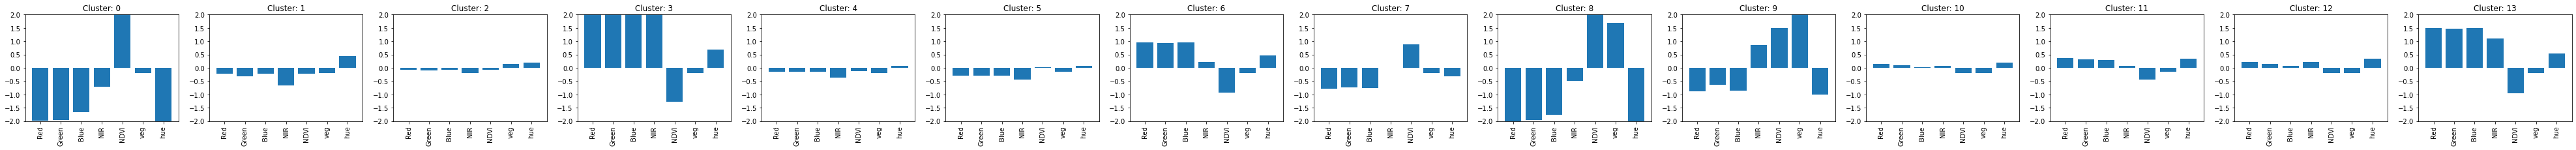

In [ ]:
fig, ax = plt.subplots(1,K,figsize=(5*K, 3))
#feature_names = feature_list[np.argmin(BIC_list)]
#number_of_variables=feature_names.shape[0]
feature_names = ['Red', 'Green', 'Blue', 'NIR', 'NDVI', 'veg', 'hue']
number_of_variables=7
for i in range(K):
  ax[i].bar(np.arange(number_of_variables), models[K-2].means_[i,:])
  ax[i].set_ylim([-2, 2])
  ax[i].set_xticks(np.arange(number_of_variables))
  ax[i].set_xticklabels(feature_names,rotation = 90)
  ax[i].set_title('Cluster: ' + str(i))
fig.savefig("feature_bars{}.png".format(K))




Per cluster, the probability of occurrence of that cluster is plotted. This could give a more clear view on the cluster distributions. 


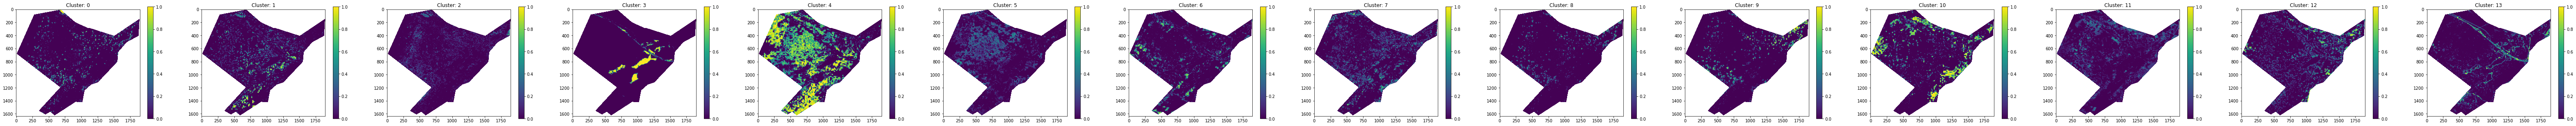

In [ ]:
prob_flat = models[K-2].predict_proba(model_input)
fig, ax = plt.subplots(1,(K),figsize=(8*(K), 5))
for i in range(K):
  prob = ax[i].imshow(get_original_shape(prob_flat[:,i]))
  prob.set_clim(0,1)
  fig.colorbar(prob, ax=ax[i])
  ax[i].set_title('Cluster: ' + str(i))
fig.savefig("Prob_dist{}.png".format(K))